In [1]:
!pip install kaggle
!pip install torch torchvision
!pip install opencv-python
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00


In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip -d /content/datasets

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
100% 565M/565M [00:01<00:00, 263MB/s]
100% 565M/565M [00:01<00:00, 369MB/s]


In [4]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
import math
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from google.colab.patches import cv2_imshow

In [5]:
style = pd.read_csv("/content/datasets/styles.csv", on_bad_lines="skip")
style.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
style.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [7]:

def crop_denoise(img_path):
    if not os.path.exists(img_path):
        return None

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    # Crop theo tỉ lệ an toàn cho áo
    top    = int(0.25 * h)
    bottom = int(0.85 * h)
    left   = int(0.10 * w)
    right  = int(0.90 * w)

    crop = img[top:bottom, left:right]

    # nếu crop quá nhỏ hoặc lỗi
    if crop.shape[0] < 0.5 * h or crop.shape[1] < 0.5 * w:
        return img   # giữ nguyên ảnh gốc
    return crop

In [8]:
style["articleType"].unique()
style["articleType"].value_counts()
style["image_path"] = style["id"].astype(str) + ".jpg"
style["image_path"] = style["image_path"].astype(str).apply(lambda x: os.path.join("/content/datasets/images/", x))

In [9]:
import random
import torch
from torch.utils.data import Dataset
from PIL import Image

class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

        # map label string -> int
        unique_labels = sorted(self.df["articleType"].unique())
        self.label2id = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.df)

    def load_image(self, path):
        img = crop_denoise(path)
        if img is None:
            return None
        return Image.fromarray(img)

    def __getitem__(self, idx):
        for _ in range(10):  # retry tối đa 10 lần
            row = self.df.iloc[idx]

            img = self.load_image(row["image_path"])
            if img is None:
                idx = random.randint(0, len(self.df) - 1)
                continue

            label_str = row["articleType"]
            label = self.label2id[label_str]

            if self.transform:
                img = self.transform(img)

            return img, torch.tensor(label, dtype=torch.long)

        raise RuntimeError("Too many bad samples (image load failed)")

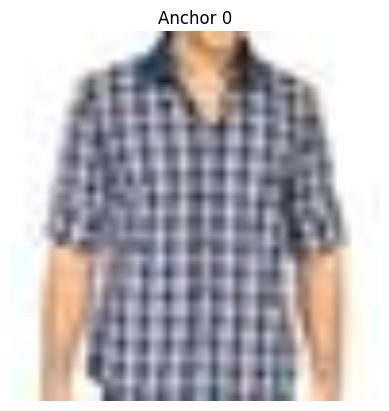

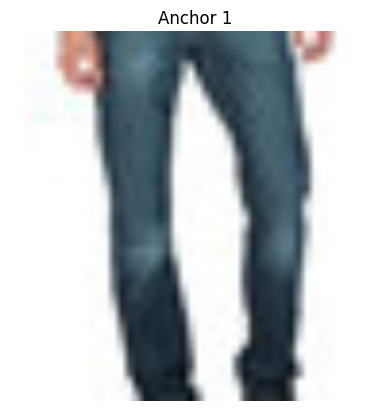

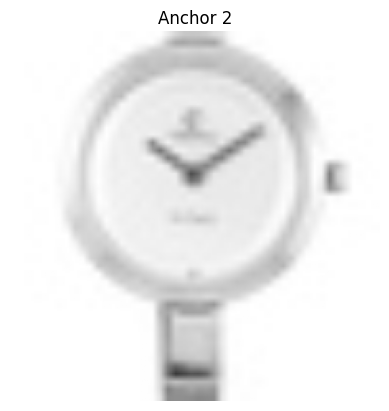

In [10]:
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = FashionDataset(style, transform=transform)


def show_tensor_image(tensor, title=""):
    img = tensor.permute(1,2,0).numpy()  # C,H,W -> H,W,C
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
for i in range(3):
    a, _ = dataset[i]
    show_tensor_image(a, f"Anchor {i}")

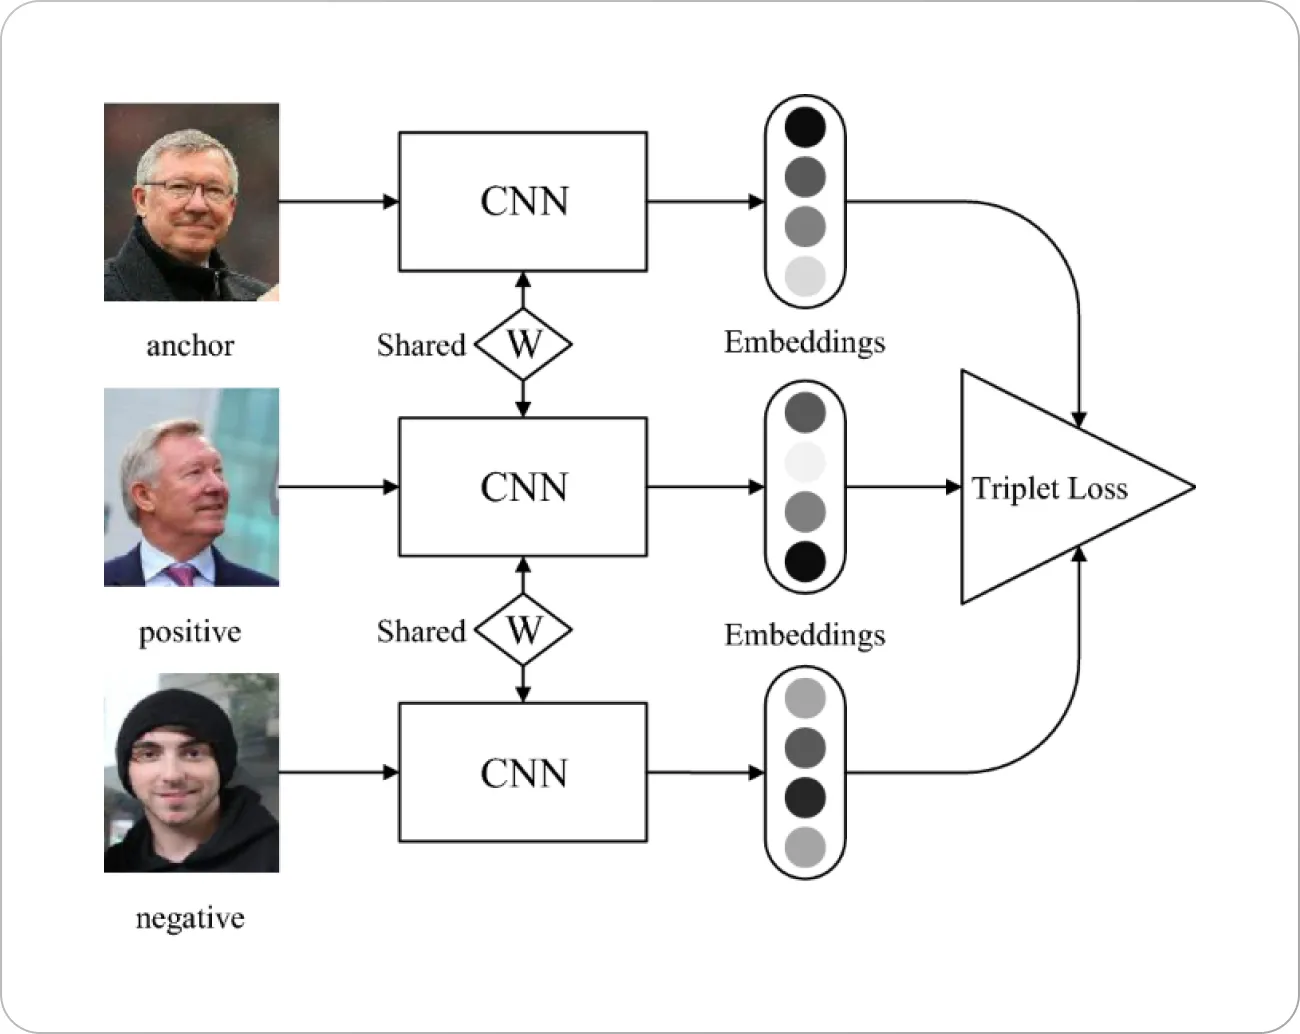

In [11]:
class ResnetBackbone(nn.Module):
  def __init__(self, name ="resnet50", pretrained= True, embedding_size =512):
    super().__init__()
    resnet = models.__dict__[name](pretrained=pretrained)
    self.features =nn.Sequential(*list(resnet.children())[:-1])
    self.fc = nn.Linear(resnet.fc.in_features,embedding_size)

  def forward(self,x):
    x= self.features(x)
    x= x.flatten(1)
    x= self.fc(x)
    return x

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        # Normalize embedding
        embeddings = F.normalize(embeddings, dim=1)

        # Pairwise distance
        dist = torch.cdist(embeddings, embeddings, p=2)  # [B, B]

        labels = labels.unsqueeze(1)
        mask_pos = labels.eq(labels.T)   # same label
        mask_neg = ~mask_pos

        # Hardest positive (xa nhất trong cùng class)
        hardest_pos = (dist * mask_pos.float()).max(dim=1)[0]

        # Hardest negative (gần nhất khác class)
        dist_neg = dist + 1e6 * mask_pos.float()
        hardest_neg = dist_neg.min(dim=1)[0]

        loss = F.relu(hardest_pos - hardest_neg + self.margin)
        return loss.mean()


In [13]:
from torch.utils.data import random_split, DataLoader

# tỷ lệ train/test
train_ratio = 0.8
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# tách dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# model = ResnetBackbone(
#     name="resnet50",
#     pretrained=True,
#     embedding_size=512
# ).to(device)


model = ResnetBackbone(
    name="resnet50",
    pretrained=False,
    embedding_size=512
).to(device)

ckpt = torch.load(
    "/content/epoch_9.pth",
    map_location=device
)

model.load_state_dict(ckpt["model_state"])

criterion = TripletLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

optimizer.load_state_dict(ckpt["optimizer_state"])
start_epoch = ckpt.get("epoch", 0) + 1


In [17]:
from tqdm import tqdm
import os

def train_one_epoch(
    model, train_loader, optimizer, criterion, device,
    epoch, ckpt_dir="checkpoints"
):
    model.train()
    total_loss = 0.0

    os.makedirs(ckpt_dir, exist_ok=True)

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for step, (imgs, labels) in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).long()

        embeddings = model(imgs)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(train_loader)

In [18]:
def save_checkpoint(model, optimizer, epoch, step, loss, path):
    torch.save({
        "epoch": epoch,
        "step": step,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss
    }, path)


In [ ]:
end_epochs = 35
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

for epoch in range(start_epoch, end_epochs):
    loss = train_one_epoch(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        epoch=epoch,
        ckpt_dir="checkpoints"
    )

    print(f"Epoch [{epoch+1}/{end_epochs}] - Loss: {loss:.4f}")

    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss
    }, f"checkpoints/epoch_{epoch}.pth")


In [32]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResnetBackbone(
    name="resnet50",
    pretrained=False,
    embedding_size=512
).to(device)

ckpt = torch.load(
    "/content/checkpoints/epoch_32.pth",
    map_location=device
)

model.load_state_dict(ckpt["model_state"])
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResnetBackbone(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_top_k_similar(model, dataset, query_idx=0, top_k=5, device="cuda"):
    model.eval()

    # Tất cả embeddings
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    all_embeddings = []
    all_imgs = []

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            emb = model(imgs)
            emb = F.normalize(emb, p=2, dim=1)
            all_embeddings.append(emb)
            all_imgs.append(imgs.cpu())

    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_imgs = torch.cat(all_imgs, dim=0)

    # Embedding query
    query_emb = all_embeddings[query_idx].unsqueeze(0)  # [1, D]

    # Tính cosine similarity
    sims = F.cosine_similarity(query_emb, all_embeddings)  # [N]

    # Top k (trừ chính nó)
    sims[query_idx] = -1.0  # bỏ chính query
    topk_vals, topk_idxs = sims.topk(top_k)

    # Hiển thị
    plt.figure(figsize=(3*(top_k+1), 3))

    # Query ảnh
    query_img = all_imgs[query_idx].permute(1,2,0).numpy()
    plt.subplot(1, top_k+1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    # Top k ảnh gần nhất
    for i, idx in enumerate(topk_idxs):
        img = all_imgs[idx].permute(1,2,0).numpy()
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(img)
        plt.title(f"Sim={topk_vals[i]:.2f}")
        plt.axis("off")

    plt.show()


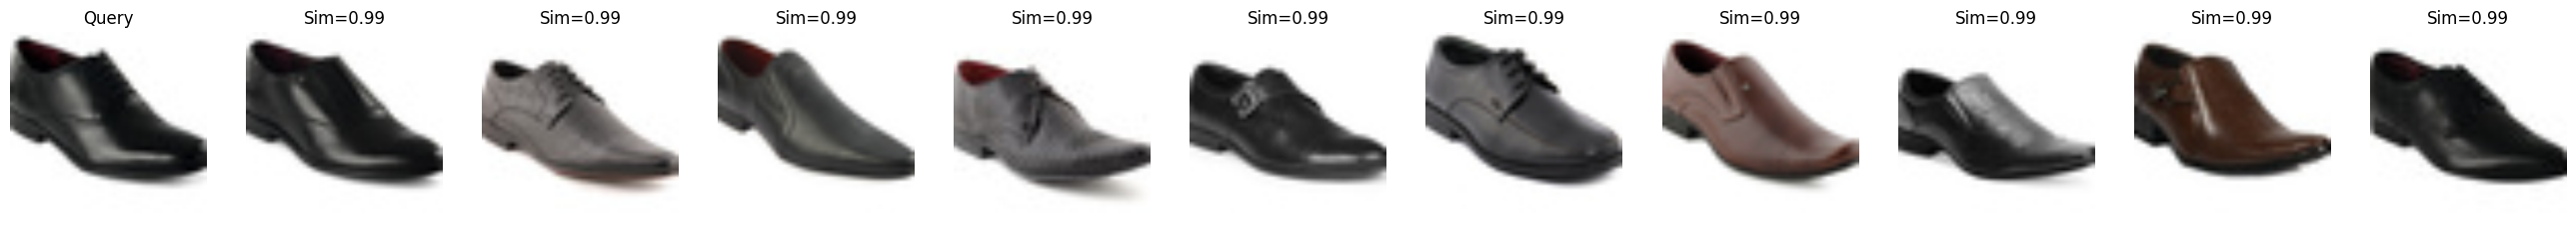

In [26]:
show_top_k_similar(model, test_dataset, query_idx=100, top_k=10, device=device)


In [20]:
import torch
import numpy as np

def extract_embeddings(model, loader, device, max_samples=1000):
    model.eval()
    embs = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            emb = model(imgs)

            embs.append(emb.cpu())
            labels.append(lbls)

            if sum(len(e) for e in embs) >= max_samples:
                break

    embs = torch.cat(embs, dim=0)[:max_samples]
    labels = torch.cat(labels, dim=0)[:max_samples]

    return embs.numpy(), labels.numpy()


In [29]:
from sklearn.manifold import TSNE

def run_tsne(embeddings):
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        init="pca",
        random_state=42
    )
    return tsne.fit_transform(embeddings)


In [22]:
import matplotlib.pyplot as plt

def plot_tsne(tsne_embs, labels):
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        tsne_embs[:, 0],
        tsne_embs[:, 1],
        c=labels,
        cmap="tab20",
        s=8
    )
    plt.colorbar(scatter)
    plt.title("t-SNE of Triplet Embeddings")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


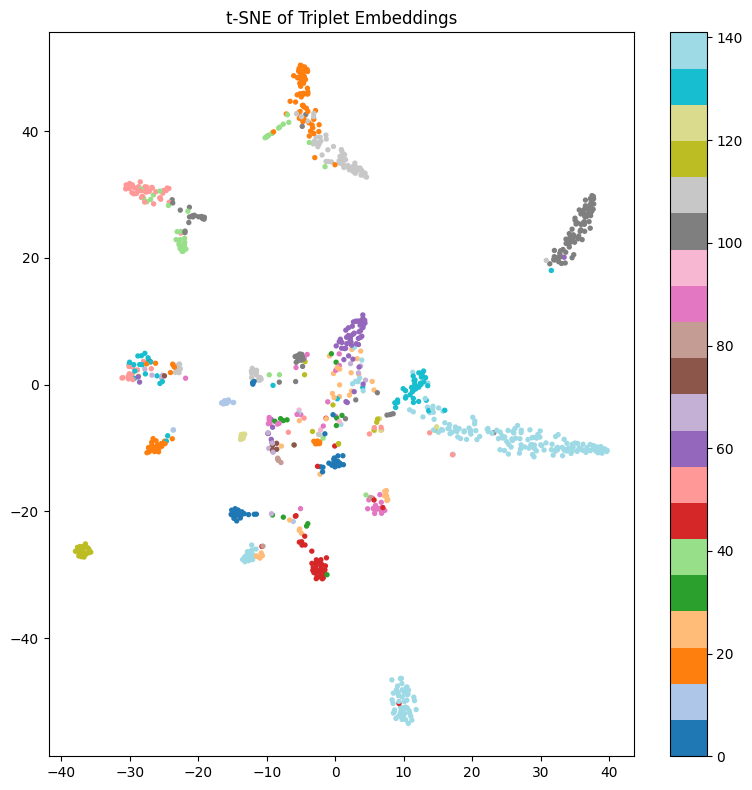

In [33]:
embs, labels = extract_embeddings(
    model,
    test_loader,
    device,
    max_samples=1000
)

tsne_embs = run_tsne(embs)
plot_tsne(tsne_embs, labels)


In [ ]:
mask = labels < 300
plot_tsne(tsne_embs[mask], labels[mask])
